In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm, jarque_bera, kstest, gamma, expon

**Type 1 Patients:**

- Scan durations are normally distributed (mean and standard deviation unknown).
- Number of patients per day follows a Poisson distribution (mean unknown). (=time between consecutive arrivals is exponentially distributed)
- **Goal:** estimate Mean & std of Average scan duration + Mean arrival rate (avg number of patients per day)

**Type 2 Patients:**
- The distributions of scan durations and arrival times are unknown.
- **Goal:** Provide the distribution of Scan Durations & Patient Arrivals. Estimate Mean & std of Average scan duration + Mean arrival rate (avg number of patients per day)

In [2]:
df = pd.read_csv("ScanRecords.csv")
df['Date'] = pd.to_datetime(df['Date'])
print("Shape of df: ", df.shape)
df.head()

Shape of df:  (618, 4)


,Date,Time,Duration,PatientType
0,2023-08-01,8.23,0.949176,Type 2
1,2023-08-01,8.49,0.479593,Type 1
2,2023-08-01,9.12,0.496112,Type 2
3,2023-08-01,10.26,0.691947,Type 2
4,2023-08-01,10.64,0.345412,Type 1


In [3]:
print(df.groupby('PatientType')['Duration'].describe())  

             count      mean       std       min       25%       50%  \
PatientType                                                            
Type 1       379.0  0.432661  0.097774  0.093731  0.368123  0.435888   
Type 2       239.0  0.669339  0.187286  0.220708  0.523962  0.646603   

                  75%       max  
PatientType                      
Type 1       0.496907  0.708922  
Type 2       0.796523  1.146789  


Type 1:
- mean: 0.4326608 = 26min
- std: 0.09777424 = 6min

Type 2:
- mean: 0.6693389 = 40min
- std: 0.1872859 = 11min

In [4]:
df1 = df[df["PatientType"] == "Type 1"]
df2 = df[df["PatientType"] == "Type 2"]

In [28]:
np.var(df1['Duration'])*60 #type 1 variance

np.float64(0.5720747257367705)

In [29]:
np.var(df2['Duration'])*60 #type 2 variance

np.float64(2.0957539720194496)

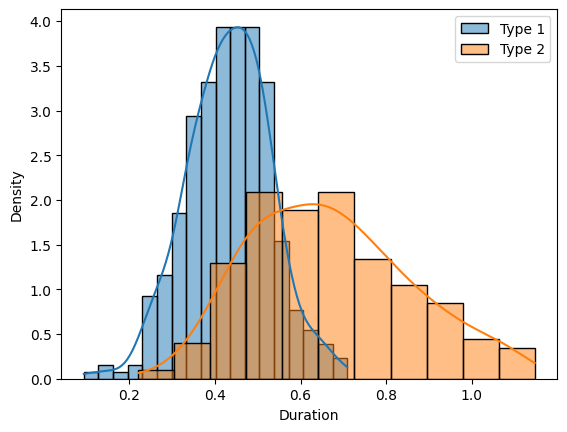

In [5]:
sns.histplot(df1["Duration"], kde=True, stat="density", label="Type 1", alpha=0.5)
sns.histplot(df2["Duration"], kde=True, stat="density", label="Type 2", alpha=0.5)

plt.legend()
plt.xlabel("Duration")
plt.ylabel("Density")
plt.show()


In [6]:
daily1 = df1['Date'].value_counts().sort_index()  # Num of Type 1 patients / day
daily2 = df2['Date'].value_counts().sort_index()  # Num of Type 2 patients / day

all_dates = pd.date_range(start=min(df1['Date'].min(), df2['Date'].min()),
                          end=max(df1['Date'].max(), df2['Date'].max()), freq='D')

daily1_ = daily1.reindex(all_dates, fill_value=0)
daily2_ = daily2.reindex(all_dates, fill_value=0)

stats = {
    "Statistic": ["Min", "Max", "Mean"],
    "Type 1 Patients": [daily1[daily1 > 0].min(), daily1_.max(), daily1_.mean()],
    "Type 2 Patients": [daily2[daily2 > 0].min(), daily2_.max(), daily2_.mean()]
}

stats_table = pd.DataFrame(stats)
stats_table.head()


,Statistic,Type 1 Patients,Type 2 Patients
0,Min,10.000000,9.000000
1,Max,23.000000,13.000000
2,Mean,12.225806,7.709677


# 1. Type 1 patients

In [7]:
df1.head()

,Date,Time,Duration,PatientType
1,2023-08-01,8.49,0.479593,Type 1
4,2023-08-01,10.64,0.345412,Type 1
5,2023-08-01,11.07,0.422270,Type 1
6,2023-08-01,11.13,0.356129,Type 1
8,2023-08-01,11.56,0.423303,Type 1


## 1.1. Scan durations

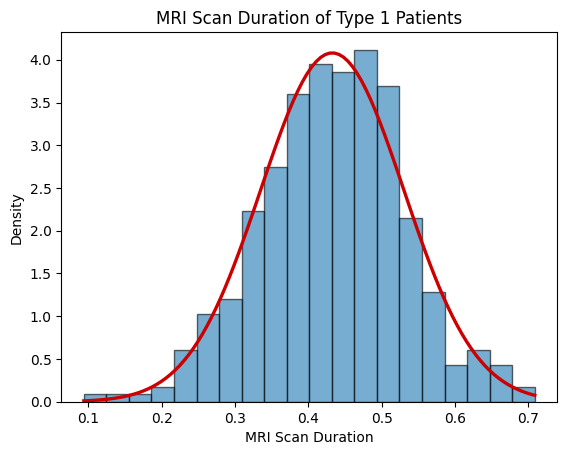

In [8]:
plt.hist(df1["Duration"], bins=20, density=True, alpha=0.6, edgecolor="black")
plt.title("MRI Scan Duration of Type 1 Patients")
plt.xlabel("MRI Scan Duration")
plt.ylabel("Density")

x_axis = np.linspace(df1["Duration"].min(), df1["Duration"].max(), 100)
mean = df1["Duration"].mean()
std_dev = df1["Duration"].std()
plt.plot(x_axis, norm.pdf(x_axis, mean, std_dev), color="#CC0000", linewidth=2.4)
plt.show()

# From ex description we already lnow that the Scan Duration is normally distributed

## 1.2. Interarrival times

In [9]:
numRows = len(df1)
interArrivals1 = []

for i in range(numRows - 1):
    if df1.iloc[i]["Date"] == df1.iloc[i + 1]["Date"]:
        # interaarival time of arrivals on the same day
        interval = df1.iloc[i + 1]["Time"] - df1.iloc[i]["Time"]
    else:
        interval = (17 - df1.iloc[i]["Time"]) + (df1.iloc[i + 1]["Time"] - 8)
    interArrivals1.append(interval)

interArrivals1 = np.array(interArrivals1)

Mean Interarrival Time: 0.55


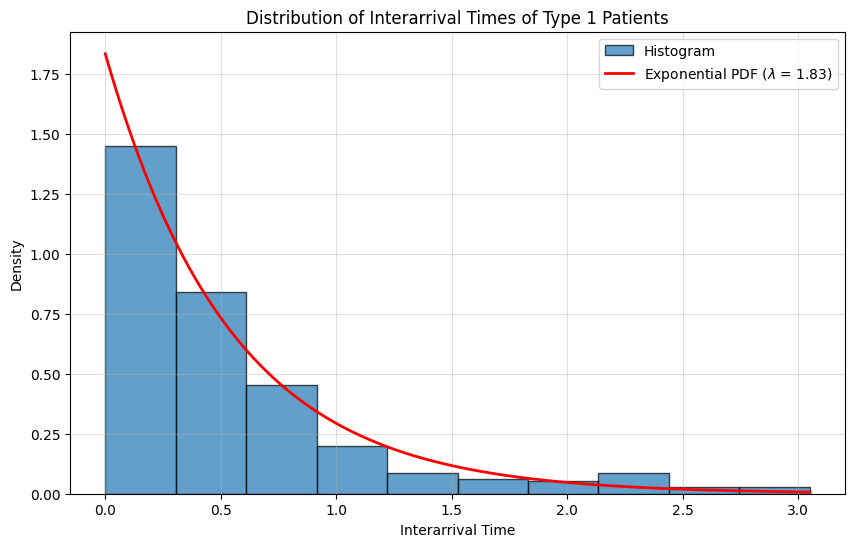

In [24]:
# mean interarrival rate 
mean_interarrival_time = interArrivals1.mean()
lambda_estimate = 1 / mean_interarrival_time

print(f"Mean Interarrival Time: {mean_interarrival_time:.2f}")

# Fit the exponential distribution 
exp_params = expon.fit(interArrivals1)  # scale (1/lambda)
lambda_est = 1 / exp_params[1]  

# exponential PDF
x_exp = np.linspace(interArrivals1.min(), interArrivals1.max(), 1000)
exp_pdf = expon.pdf(x_exp, *exp_params)

plt.figure(figsize=(10, 6))
plt.hist(interArrivals1, bins=10, density=True, alpha=0.7, edgecolor='black', label="Histogram")
plt.plot(x_exp, exp_pdf, 'r-', label=f'Exponential PDF ($\\lambda$ = {lambda_est:.2f})', linewidth=2)
plt.title("Distribution of Interarrival Times of Type 1 Patients")
plt.xlabel("Interarrival Time")
plt.ylabel("Density")
plt.legend()
plt.grid(alpha=0.4)
plt.show()


# 2. Type 2 patients

## 2.1. Scan duration

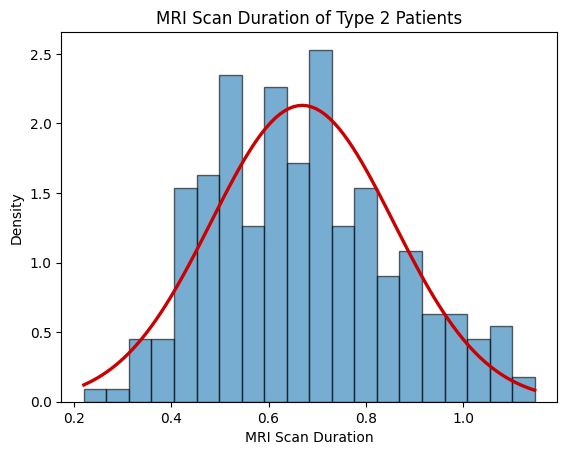

In [12]:
plt.hist(df2["Duration"], bins=20, density=True, alpha=0.6, edgecolor="black")
plt.title("MRI Scan Duration of Type 2 Patients")
plt.xlabel("MRI Scan Duration")
plt.ylabel("Density")

x_axis = np.linspace(df2["Duration"].min(), df2["Duration"].max(), 100)
mean = df2["Duration"].mean()
std_dev = df2["Duration"].std()
plt.plot(x_axis, norm.pdf(x_axis, mean, std_dev), color="#CC0000", linewidth=2.4)
plt.show()

Based on the histogram, the slight positive skew in the distribution suggests that a gamma distribution could be a good fit.

In [13]:
# Normality test: Jarque-Bera test
stat, p = jarque_bera(df2['Duration'])

print("Jarque-Bera Test for Normality:")
print(f"Statistic: {stat:.4f}, p-value: {p:.4f}")

if p > 0.05:
    print("fail to reject H_0")
else:
    print("reject H_0")


Jarque-Bera Test for Normality:
Statistic: 7.1767, p-value: 0.0276
reject H_0


In [14]:
# Gamma dist test: KS - test
gamma_params = gamma.fit(df2['Duration'], floc=0) 
gamma_shape, gamma_loc, gamma_scale = gamma_params

ks_stat, p_value = kstest(df2['Duration'], 'gamma', args=(gamma_shape, gamma_loc, gamma_scale))

# Output results
print("Kolmogorov-Smirnov Test for Gamma Distribution:")
print(f"KS Statistic: {ks_stat:.4f}, p-value: {p_value:.4f}")

if p_value > 0.05:
    print("fail to reject H_0")
else:
    print("reject H_0")
    

Kolmogorov-Smirnov Test for Gamma Distribution:
KS Statistic: 0.0423, p-value: 0.7695
fail to reject H_0


In [15]:
print("Gamma Distribution Parameters:")
print(f"Shape (k): {gamma_shape:.4f}")
print(f"Scale (theta): {gamma_scale:.4f}")

Gamma Distribution Parameters:
Shape (k): 12.5848
Scale (theta): 0.0532


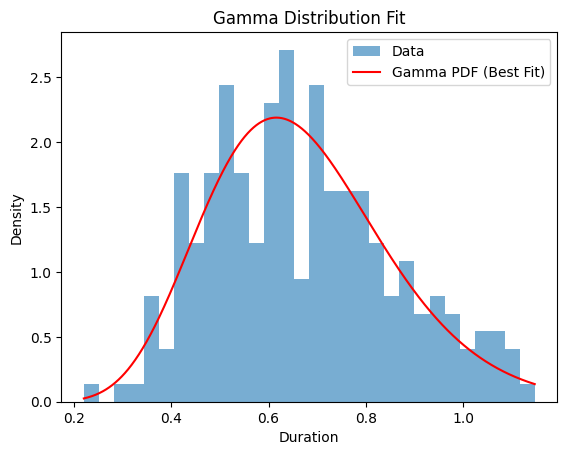

In [16]:
x = np.linspace(min(df2['Duration']), max(df2['Duration']), 1000)
gamma_pdf = gamma.pdf(x, gamma_shape, loc=gamma_loc, scale=gamma_scale)

plt.hist(df2['Duration'], bins=30, density=True, alpha=0.6, label='Data')
plt.plot(x, gamma_pdf, 'r-', label='Gamma PDF (Best Fit)')
plt.title("Gamma Distribution Fit")
plt.xlabel("Duration")
plt.ylabel("Density")
plt.legend()
plt.show()

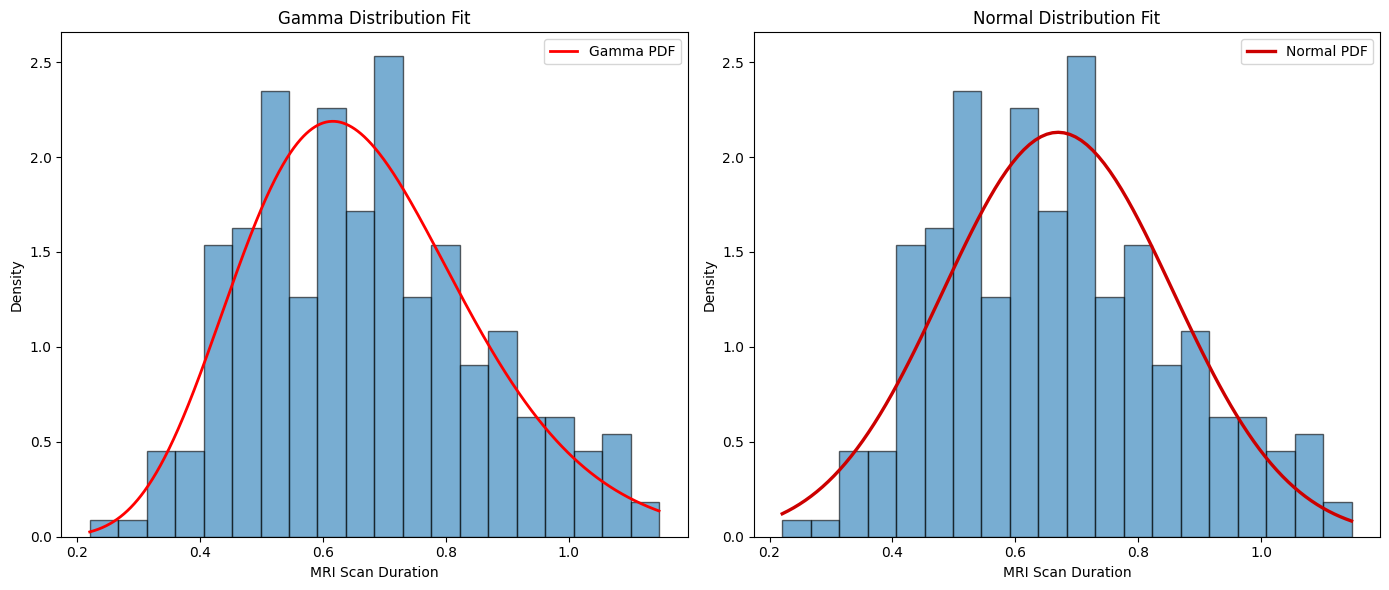

In [17]:
x_axis = np.linspace(df2["Duration"].min(), df2["Duration"].max(), 100)

mean = df2["Duration"].mean()
std_dev = df2["Duration"].std()
normal_pdf = norm.pdf(x_axis, mean, std_dev)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# histogram with Gamma distribution 
axes[0].hist(df2["Duration"], bins=20, density=True, alpha=0.6, edgecolor="black")
axes[0].plot(x, gamma_pdf, 'r-', label='Gamma PDF', linewidth=2)
axes[0].set_title("Gamma Distribution Fit")
axes[0].set_xlabel("MRI Scan Duration")
axes[0].set_ylabel("Density")
axes[0].legend()

# histogram with Normal distribution 
axes[1].hist(df2["Duration"], bins=20, density=True, alpha=0.6, edgecolor="black")
axes[1].plot(x_axis, normal_pdf, color="#CC0000", linewidth=2.4, label="Normal PDF")
axes[1].set_title("Normal Distribution Fit")
axes[1].set_xlabel("MRI Scan Duration")
axes[1].set_ylabel("Density")
axes[1].legend()

plt.tight_layout()
plt.show()

## 2.2. Interarrival times

In [18]:
numRows = len(df2)
interArrivals2 = []

for i in range(numRows - 1):
    if df2.iloc[i]["Date"] == df2.iloc[i + 1]["Date"]:
        # interaarival time of arrivals on the same day
        interval = df2.iloc[i + 1]["Time"] - df2.iloc[i]["Time"]
    else:
        interval = (17 - df2.iloc[i]["Time"]) + (df2.iloc[i + 1]["Time"] - 8)
    interArrivals2.append(interval)

interArrivals2 = np.array(interArrivals2)

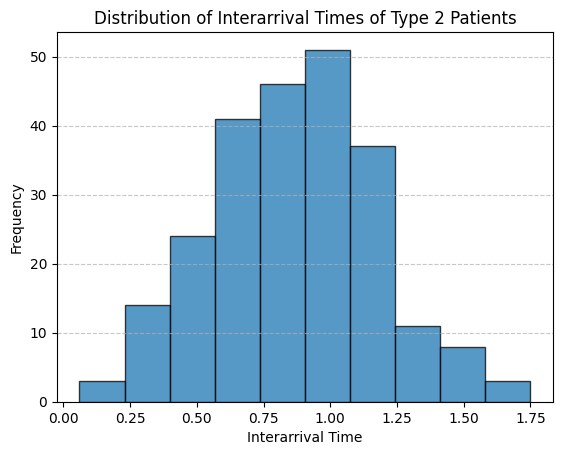

In [19]:
plt.hist(interArrivals2, bins=10, edgecolor="black", alpha=0.75)
plt.title("Distribution of Interarrival Times of Type 2 Patients")
plt.xlabel("Interarrival Time")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Based on the histogram, it looks like the normal distribution could be a good fit. We could also test it against the gamma distribution again

In [20]:
# Gamma dist test: KS - test
gamma_params = gamma.fit(interArrivals2, floc=0) 
gamma_shape, gamma_loc, gamma_scale = gamma_params

ks_stat, p_value = kstest(interArrivals2, 'gamma', args=(gamma_shape, gamma_loc, gamma_scale))

# Output results
print("Kolmogorov-Smirnov Test for Gamma Distribution:")
print(f"KS Statistic: {ks_stat:.4f}, p-value: {p_value:.4f}")

if p_value > 0.05:
    print("fail to reject H_0")
else:
    print("reject H_0")


Kolmogorov-Smirnov Test for Gamma Distribution:
KS Statistic: 0.0952, p-value: 0.0251
reject H_0


In [21]:
# Normality test: Jarque-Bera test
stat, p = jarque_bera(interArrivals2)

print("Jarque-Bera Test for Normality:")
print(f"Statistic: {stat:.4f}, p-value: {p:.4f}")

if p > 0.05:
    print("fail to reject H_0")
else:
    print("reject H_0")

Jarque-Bera Test for Normality:
Statistic: 0.7766, p-value: 0.6782
fail to reject H_0


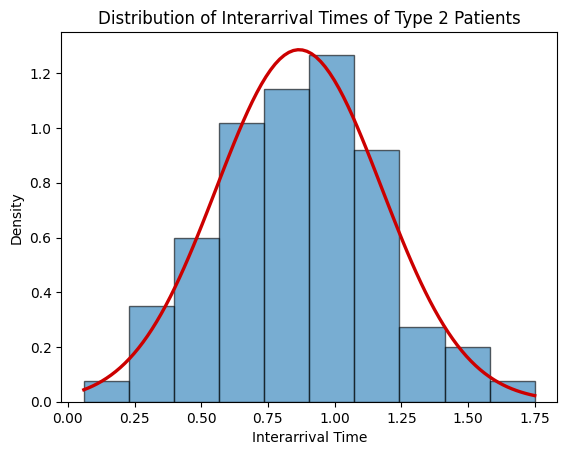

In [26]:
plt.hist(interArrivals2, bins=10, density=True, alpha=0.6, edgecolor="black")
plt.title("Distribution of Interarrival Times of Type 2 Patients")
plt.xlabel("Interarrival Time")
plt.ylabel("Density")

x_axis = np.linspace(interArrivals2.min(), interArrivals2.max(), 100)
mean = interArrivals2.mean()
std_dev = interArrivals2.std()
plt.plot(x_axis, norm.pdf(x_axis, mean, std_dev), color="#CC0000", linewidth=2.4)
plt.show()